## Context

## Objective

- Explore and visualize the dataset (first part)


### Overall solution design :

The potential solution design would look like this:

- Checking the data description to get the idea of basic statistics or summary of data.
- Univariate analysis to see how data is spread out, getting to know about the outliers.
- Bivariate analysis to see how different attributes vary with the dependent variable.
- Outlier treatment if needed.
- Missing value treatment using appropriate techniques.
- Feature engineering - transforming features, creating new features if possible.
- Choosing the model evaluation technique - 1) R Squared 2) RMSE can be any other metrics related to regression analysis.
- Splitting the data and proceeding with modeling.


## Importing the necessary libraries and overview of the dataset

In [13]:
# Importing the basic libraries we will require for the project

# Import libraries for data manipulation
import pandas as pd
import numpy as np
import os
# Import libraries for data visualization
import matplotlib.pyplot as plt

# Slightly advanced library for data visualization            
import seaborn as sns      

# Import necessary modules
import geopandas as gpd
from geopy.exc import GeocoderTimedOut, GeocoderServiceError

# import module for geoencoding
from geopy.geocoders import Nominatim

#We can use the function identify_nominal_columns(dataset) of the dython library to identify the categorical variables in the dataset.
from dython.nominal import associations

# add sleep time
from time import sleep

import logging

# Set up the color sheme:
import mapclassify as mc

# to compute zscores: https://pypi.org/project/cgmzscore/
# Resource R: https://rdrr.io/github/WorldHealthOrganization/anthroplus/man/anthroplus_zscores.html
#from cgmzscore.src.main import z_score_lhfa
#from cgmzscore.src.main import z_score_wfa
#import ast
#https://github.com/ewheeler/pygrowup
#from pygrowup import Observation
#from decimal import Decimal

import datetime
# Release memory using gc : The gc module to manually trigger garbage collection. 
# Garbage collection is the process of freeing memory that is no longer being used by the program. 
# By manually triggering garbage collection, you can release memory that is no longer needed.
import gc

gc.collect()


1023

## Functions

In [5]:
# def return_non_na(curr_data,col):
#     return curr_data[col].replace(['HWHAZWHO', 'HWWAZWHO', 'HWWHZWHO','HWBMIZWHO','Missing'], np.NaN, inplace=True)



def reverse_geocode(geolocator, latlon, sleep_sec):
    """
    This function attempts to perform reverse geocoding using the provided geolocator
    and latitude-longitude coordinates. It handles potential errors and retries on timeouts.

    Args:
        geolocator (object): A geocoding library object used for reverse geocoding.
        latlon (str): A string in the format "latitude,longitude" representing the location.
        sleep_sec (int): The maximum number of seconds to sleep between retries on timeouts.

    Returns:
        object: The result of the reverse geocoding request (may vary depending on the geocoder library).
                - On success, returns the geocoded information.
                - On timeout, retries up to sleep_sec seconds and returns the result.
                - On service error or other exceptions, returns None.
    """

    try:
        # Attempt reverse geocoding using the geolocator in English language
        return geolocator.reverse(latlon, language='en')
    except GeocoderTimedOut:
        # Handle timeout error
        logging.info('TIMED OUT: GeocoderTimedOut: Retrying...')
        # Introduce a random sleep between 1 and sleep_sec seconds to avoid overwhelming the service
        sleep(randint(1 * 100, sleep_sec * 100) / 100)
        # Retry the reverse geocoding with the same parameters
        return reverse_geocode(geolocator, latlon, sleep_sec)
    except GeocoderServiceError as e:
        # Handle service error (e.g., connection refused)
        logging.info('CONNECTION REFUSED: GeocoderServiceError encountered.')
        logging.error(e)  # Log the detailed error for debugging
        return None  # Indicate failure
    except Exception as e:
        # Handle unexpected exceptions
        logging.info('ERROR: Terminating due to exception {}'.format(e))
        return None  # Indicate failure
    

def get_local_information(curr_data, sleep_sec):
    """
    This function enriches a DataFrame with local address information based on latitude and longitude data.

    Args:
        curr_data (pandas.DataFrame): A DataFrame with columns 'LATNUM' and 'LONGNUM' containing latitude and longitude values.
        sleep_sec (int): Number of seconds to sleep between retries for error handling.

    Returns:
        pandas.DataFrame: The DataFrame with additional columns for city, village, county, state_district, state, and country.
        """

    # Initialize the Nominatim geocoder with a user agent string (important for API usage guidelines)
    user_agent = 'bibouPaultest_{}'.format(randint(10000, 99999)) + '@gmail.com'
    geolocator = Nominatim(user_agent=user_agent)

    # Iterate through each row of the DataFrame
    for curr_line in range(curr_data.index.max() + 1):

        # Extract latitude and longitude values for the current row
        Latitude = str(curr_data.loc[curr_line, "LATNUM"])
        Longitude = str(curr_data.loc[curr_line, "LONGNUM"])

        # Perform reverse geocoding to get address information
        location = reverse_geocode(geolocator, Latitude + "," + Longitude, sleep_sec)  # Uses a custom function for retries

        # Extract relevant address components from the geocoding result
        if location:
            address = location.raw['address']
            city = address.get('city')
            village = address.get('village')
            county = address.get('county')
            state_district = address.get('state_district')
            state = address.get('state')
            country = address.get('country')

        # Update the DataFrame with the extracted address information
            curr_data.loc[curr_line, 'city'] = city
            curr_data.loc[curr_line, 'village'] = village
            curr_data.loc[curr_line, 'county'] = county
            curr_data.loc[curr_line, 'state_district'] = state_district
            curr_data.loc[curr_line, 'state'] = state
            curr_data.loc[curr_line, 'country'] = country

        else:
            # Update the DataFrame with the extracted address information
            curr_data.loc[curr_line, 'city'] = np.NAN
            curr_data.loc[curr_line, 'village'] = np.NAN
            curr_data.loc[curr_line, 'county'] = np.NAN
            curr_data.loc[curr_line, 'state_district'] = np.NAN
            curr_data.loc[curr_line, 'state'] = np.NAN
            curr_data.loc[curr_line, 'country'] = np.NAN
    
    # Return the DataFrame with the added address information
    return curr_data


def correct_id(curr_row, nbr_max):
    """
    This function ensures that the input string `curr_row` is formatted to a specified length `nbr_max` 
    by adding leading zeros if necessary.

    Parameters:
    curr_row (str): The current row ID that needs to be corrected.
    nbr_max (int): The maximum length that the corrected ID should have.
    """
    # Check if the length of the current row ID is less than the maximum allowed length
    if len(curr_row) < nbr_max:
        # Calculate the number of leading zeros needed to reach the maximum length
        nbr_resid = nbr_max - len(curr_row) 
        # Add the leading zeros to the beginning of the current row ID and return as a string
        if curr_row.count('.') == 0:
            return str(nbr_resid * '0' + curr_row)
        else:
            # Add extra leading zeros if the current row ID contains a period (.)
            return str((nbr_resid + 2) * '0' + curr_row)
    # Check if the length of the current row ID is exactly equal to the maximum allowed length
    elif len(curr_row) == nbr_max:
        # Return the current row ID as a string, adding two leading zeros if it contains a period
        if curr_row.count('.') == 0:
            return str(curr_row)
        else:
            return str(2 * '0' + curr_row)
    # Case where the length of the current row ID is greater than the maximum allowed length
    else: 
        # Check if the period is in the third position
        if curr_row.find('.') == 2: 
            return str('00' + curr_row)
        # Check if the period is in the fourth position
        elif curr_row.find('.') == 3: 
            return str('0' + curr_row)
        # Return the current row ID as is
        else: 
            return str(curr_row)
        
def formatNumber(num):
    # Check if the number is an integer (i.e., no fractional part)
    if num % 1 == 0:
        # If it is an integer, convert it to an integer type and return it
        return int(num)
    else:
        # If it is not an integer, return the number as it is
        return num
    
def vertical_mean_line_survived(x, **kwargs):
    """
    This function draws a vertical line on a plot at the mean value of the input data 'x'.
    The style and color of the line are determined by additional keyword arguments.

    Parameters:
    x (array-like): The data for which the mean will be calculated.
    **kwargs: Additional keyword arguments to customize the line.
        'label' (str): A label that can be 'male' or 'female' to determine the line style.
        'color' (str): The color of the line, default is green ('g').

    Example usage:
    vertical_mean_line_survived(data, label='male', color='b')
    """

    # Define line styles for male and female
    ls = {"male": "-", "female": "-"}
    
    # Draw a vertical line at the mean of 'x'
    plt.axvline(x.mean(), 
                linestyle=ls[kwargs.get("label")],  # Set line style based on 'label' keyword argument
                color=kwargs.get("color", "g"))     # Set line color based on 'color' keyword argument, default is green

# Example of how the function might be called:
# vertical_mean_line_survived(data, label='male', color='blue')

## Loading the data

In [7]:
# Round 1 datasets
df_r1_hh = pd.read_excel(os.getcwd() + '\\output\\data\\r1_hh.xlsx') 
df_r1_anthr1 = pd.read_excel(os.getcwd() + '\\output\\data\\r1_overfive.xlsx') 
df_r1_anthr2 = pd.read_excel(os.getcwd() + '\\output\\data\\r1_underfive.xlsx') 

# Round 2 datasets
df_r2_hh = pd.read_excel(os.getcwd() + '\\output\\data\\r2_hh.xlsx') 
df_r2_anthr1 = pd.read_excel(os.getcwd() + '\\output\\data\\r2_overfive.xlsx') 
df_r2_anthr2 = pd.read_excel(os.getcwd() + '\\output\\data\\r2_underfive.xlsx') 

# Round 3 datasets
df_r3_hh = pd.read_excel(os.getcwd() + '\\output\\data\\r3_hh.xlsx') 
df_r3_anthr1 = pd.read_excel(os.getcwd() + '\\output\\data\\r3_overfive.xlsx') 
df_r3_anthr2 = pd.read_excel(os.getcwd() + '\\output\\data\\r3_underfive.xlsx') 

# Importing the Bangladesh raw map: Reading a shapefile containing administrative boundaries of Bangladesh
bgd_adm = gpd.read_file(os.getcwd() + '\\input\\shapefile_data\\shapefile_zip\\BGD_adm\\BGD_adm3.shp')

In [ ]:
# removing splitted household



## Exploratory Data Analysis

Now that we have loaded the datasets, the next step to follow is to have a better understanding of the dataset, i.e., what is the distribution of the variables, what are different relationships that exist between variables, etc. If there are any data anomalies like missing values or outliers, how do we treat them to prepare the dataset for building the model?


### Missing values

#### Round 1

In [8]:
# Missing values
pd.DataFrame(data={'% of Missing Values':round(df_r1_hh.isna().sum()/df_r1_hh.isna().count()*100,2),'Nbr of Missing Values':df_r1_hh.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


,% of Missing Values,Nbr of Missing Values
Unnamed: 0,0.0,0
division_code,0.0,0
code adm,0.0,0
interview_status_r3,0.0,0
interview_status_r2,0.0,0
survey_round,0.0,0
hh_id_cmplt,0.0,0
date_int,0.0,0
sample_type,0.0,0
first_v_year,0.0,0


In [9]:
# Missing values
pd.DataFrame(data={'% of Missing Values':round(df_r1_anthr1.isna().sum()/df_r1_anthr1.isna().count()*100,2),'Nbr of Missing Values':df_r1_anthr1.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


,% of Missing Values,Nbr of Missing Values
are_you_lactating,48.63,9926
are_you_pregnant,48.56,9912
height_cm,6.56,1338
weight_kg,6.40,1306
Unnamed: 0,0.00,0
first_v_month,0.00,0
upazila_name,0.00,0
union_code,0.00,0
union_name,0.00,0
census_nbr,0.00,0


In [10]:
# Missing values
pd.DataFrame(data={'% of Missing Values':round(df_r1_anthr2.isna().sum()/df_r1_anthr2.isna().count()*100,2),'Nbr of Missing Values':df_r1_anthr2.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


,% of Missing Values,Nbr of Missing Values
if_not_week_month,93.61,2316
height_cm,4.24,105
weight_kg,3.15,78
age_days,0.65,16
month_birth,0.65,16
year_birth,0.65,16
date_birth,0.65,16
first_v_month,0.00,0
upazila_code,0.00,0
upazila_name,0.00,0


#### Round 2

In [ ]:
# Missing values
pd.DataFrame(data={'% of Missing Values':round(df_r2_hh.isna().sum()/df_r2_hh.isna().count()*100,2),'Nbr of Missing Values':df_r2_hh.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


In [ ]:
# Missing values
pd.DataFrame(data={'% of Missing Values':round(df_r2_anthr1.isna().sum()/df_r2_anthr1.isna().count()*100,2),'Nbr of Missing Values':df_r2_anthr1.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


In [ ]:
# Missing values
pd.DataFrame(data={'% of Missing Values':round(df_r2_anthr2.isna().sum()/df_r2_anthr2.isna().count()*100,2),'Nbr of Missing Values':df_r2_anthr2.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


#### Round 3

In [ ]:
# Missing values
pd.DataFrame(data={'% of Missing Values':round(df_r3_hh.isna().sum()/df_r3_hh.isna().count()*100,2),'Nbr of Missing Values':df_r3_hh.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


In [ ]:
# Missing values
pd.DataFrame(data={'% of Missing Values':round(df_r3_anthr1.isna().sum()/df_r3_anthr1.isna().count()*100,2),'Nbr of Missing Values':df_r3_anthr1.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


In [ ]:
# Missing values
pd.DataFrame(data={'% of Missing Values':round(df_r3_anthr2.isna().sum()/df_r3_anthr2.isna().count()*100,2),'Nbr of Missing Values':df_r3_anthr2.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


### Correlation matrix

In [23]:
associations(df_r1_hh[["hh_head_religion","hh_ethnic_group","affected_upazila","interview_status_r2","interview_status_r3"]],plot=False)['corr'].dropna(axis=1, how='all').dropna(axis=0, how='all').style.background_gradient(cmap='coolwarm', axis=None)


,hh_head_religion,hh_ethnic_group,affected_upazila,interview_status_r2,interview_status_r3
hh_head_religion,1.000000,0.118699,0.057528,0.000000,0.038000
hh_ethnic_group,0.118699,1.000000,0.039236,0.000000,0.000000
affected_upazila,0.057528,0.039236,1.000000,0.045196,0.070400
interview_status_r2,0.000000,0.000000,0.045196,1.000000,0.296001
interview_status_r3,0.038000,0.000000,0.070400,0.296001,1.000000


## Some graphics

### Round 1

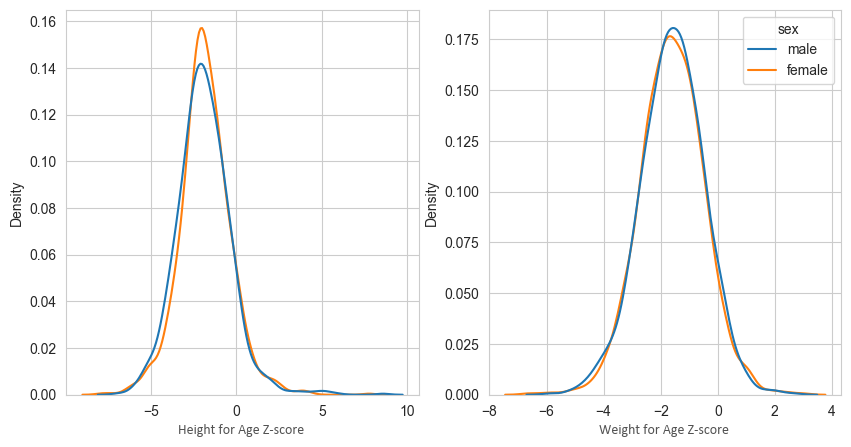

<Figure size 640x480 with 0 Axes>

In [ ]:
#  Set labels’ font parameters
sns.set_style("whitegrid")
font_color = '#525252'
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))

sns.kdeplot(data=df_r1_anthr2, x="HAZ", hue="sex", ax=ax[0], legend=False)
ax[0].set_xlabel("Height for Age Z-score ", fontsize=10, color=font_color, **hfont)

sns.kdeplot(data=df_r1_anthr2, x="WAZ", hue="sex", ax=ax[1], legend=True)
ax[1].set_xlabel("Weight for Age Z-score ", fontsize=10, color=font_color, **hfont)



#plt.legend(labels= ['Male', 'Female'], loc = (1.04,0.85))
plt.grid(True)
plt.show()

filename = 'r1-Z-score dist'
plt.savefig(os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)



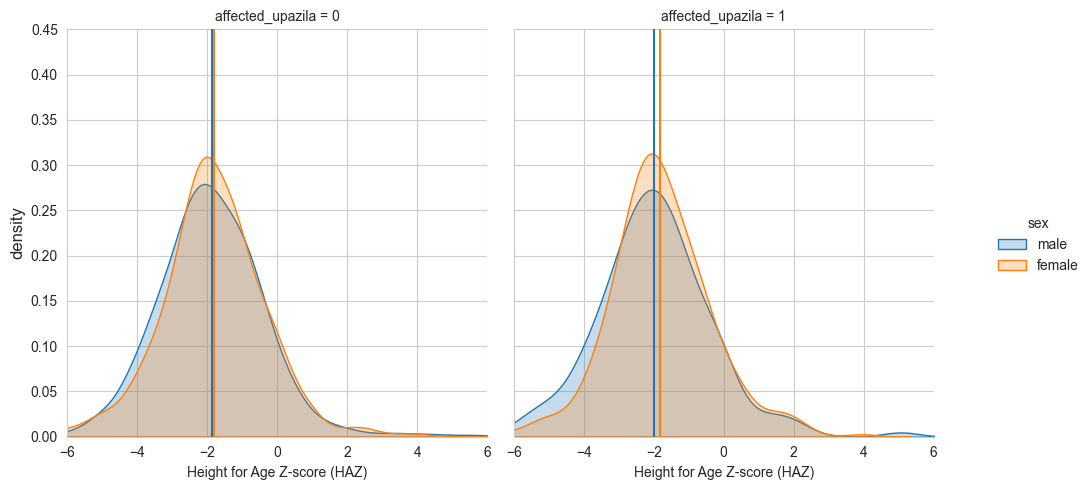

In [ ]:
g = sns.FacetGrid(df_r1_anthr2, col="affected_upazila", hue="sex", margin_titles=True, ylim=(0, 0.45), xlim=(-6, 6),sharex=True, sharey=True, height=5, aspect=1)
g.map(sns.kdeplot, "HAZ",  fill=True)
g.add_legend()

g.map(vertical_mean_line_survived, 'HAZ')

g.set_axis_labels("Height for Age Z-score (HAZ)")
g.set_ylabels('density', size=12)

filename="by_gender_distribution_haz_norm_r1"
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg')

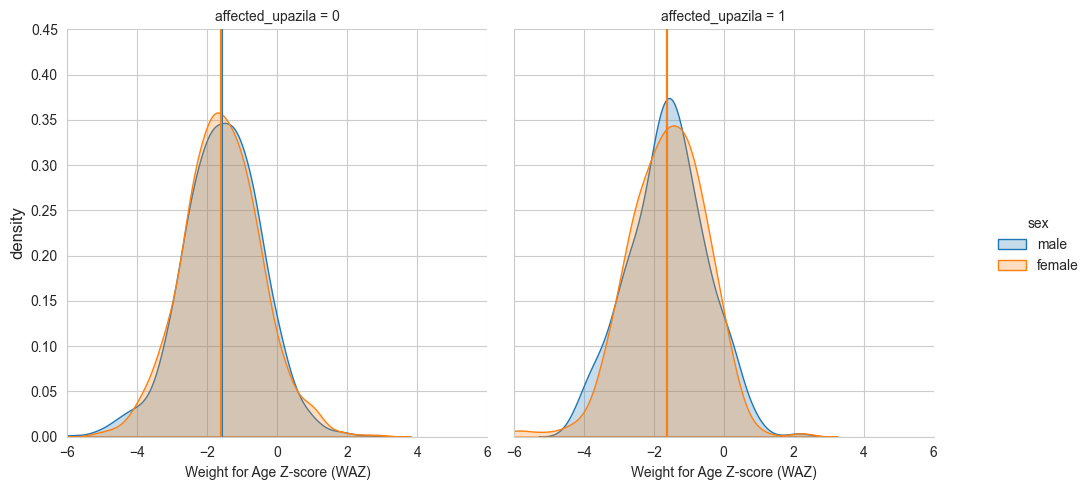

In [ ]:
g = sns.FacetGrid(df_r1_anthr2, col="affected_upazila", hue="sex", margin_titles=True, ylim=(0, 0.45), xlim=(-6, 6),sharex=True, sharey=True,height=5, aspect=1)
g.map(sns.kdeplot, "WAZ",  fill=True)
g.add_legend()

g.map(vertical_mean_line_survived, 'WAZ')

g.set_axis_labels("Weight for Age Z-score (WAZ)")
g.set_ylabels('density', size=12)

filename="by_gender_distribution_waz_norm_r1"
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg')

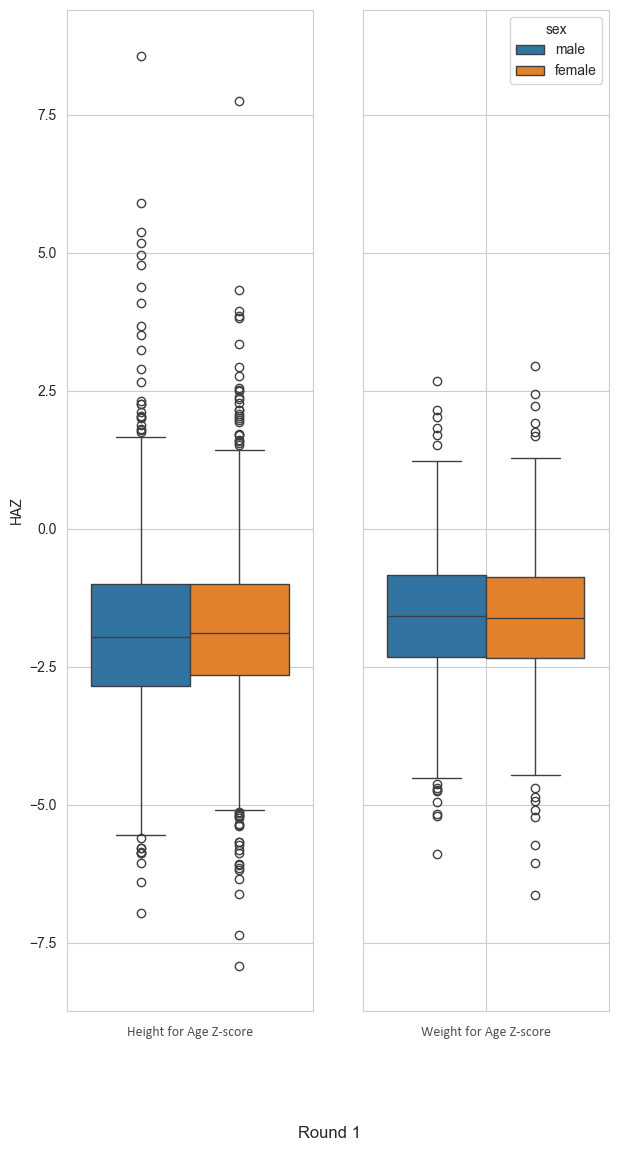

<Figure size 640x480 with 0 Axes>

In [ ]:
#  Set labels’ font parameters
sns.set_style("whitegrid")
font_color = '#525252'
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'

# Représentation graphique des regions du Bangladesh

## fig et ax représentent la base de la carte
fig, ax = plt.subplots(nrows=1,ncols=2,sharex=True, sharey=True, figsize=(7,13))

sns.boxplot(data=df_r1_anthr2, y="HAZ", hue="sex", ax=ax[0], legend=False)
ax[0].set_xlabel("Height for Age Z-score", fontsize=10, color=font_color, **hfont)


sns.boxplot(data=df_r1_anthr2, y="WAZ", hue="sex", ax=ax[1])
ax[1].set_xlabel("Weight for Age Z-score", fontsize=10, color=font_color, **hfont)

fig.supxlabel('Round 1')

plt.grid(True)
plt.show()

filename = 'r1_boxplot'
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)

### Round 2

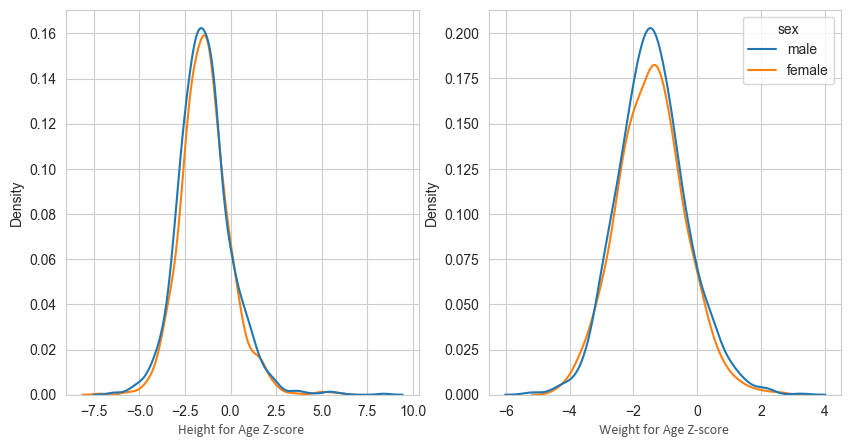

<Figure size 640x480 with 0 Axes>

In [ ]:
#  Set labels’ font parameters
sns.set_style("whitegrid")
font_color = '#525252'
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))

sns.kdeplot(data=df_r2_anthr2, x="HAZ", hue="sex", ax=ax[0], legend=False)
ax[0].set_xlabel("Height for Age Z-score ", fontsize=10, color=font_color, **hfont)

sns.kdeplot(data=df_r2_anthr2, x="WAZ", hue="sex", ax=ax[1], legend=True)
ax[1].set_xlabel("Weight for Age Z-score ", fontsize=10, color=font_color, **hfont)



#plt.legend(labels= ['Male', 'Female'], loc = (1.04,0.85))
plt.grid(True)
plt.show()

filename = 'r2-Z-score dist'
plt.savefig(os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)

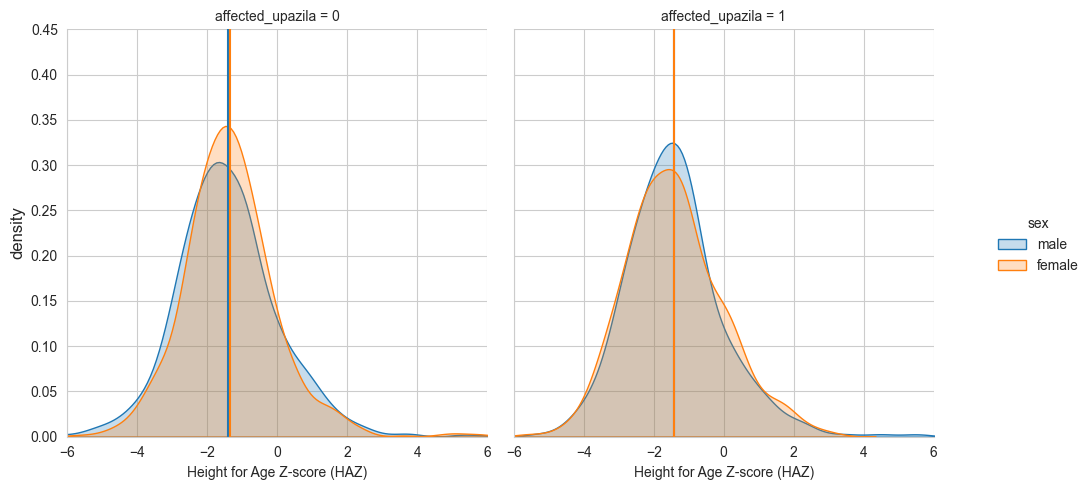

In [ ]:
g = sns.FacetGrid(df_r2_anthr2, col="affected_upazila", hue="sex", margin_titles=True, ylim=(0, 0.45), xlim=(-6, 6),sharex=True, sharey=True, height=5, aspect=1)
g.map(sns.kdeplot, "HAZ",  fill=True)
g.add_legend()

g.map(vertical_mean_line_survived, 'HAZ')

g.set_axis_labels("Height for Age Z-score (HAZ)")
g.set_ylabels('density', size=12)

filename="by_gender_distribution_haz_norm_r2"
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg')

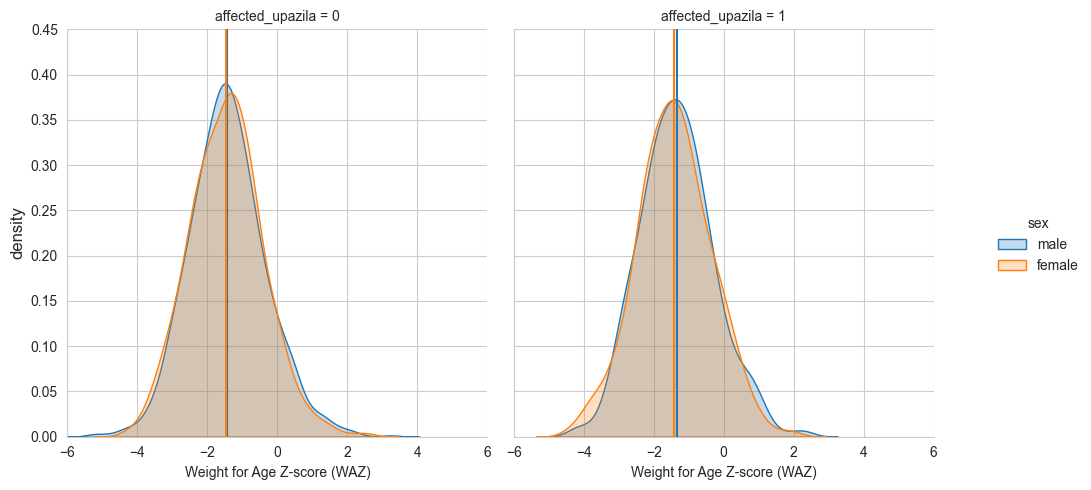

In [ ]:
g = sns.FacetGrid(df_r2_anthr2, col="affected_upazila", hue="sex", margin_titles=True, ylim=(0, 0.45), xlim=(-6, 6),sharex=True, sharey=True,height=5, aspect=1)
g.map(sns.kdeplot, "WAZ",  fill=True)
g.add_legend()

g.map(vertical_mean_line_survived, 'WAZ')

g.set_axis_labels("Weight for Age Z-score (WAZ)")
g.set_ylabels('density', size=12)

filename="by_gender_distribution_waz_norm_r2"
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg')

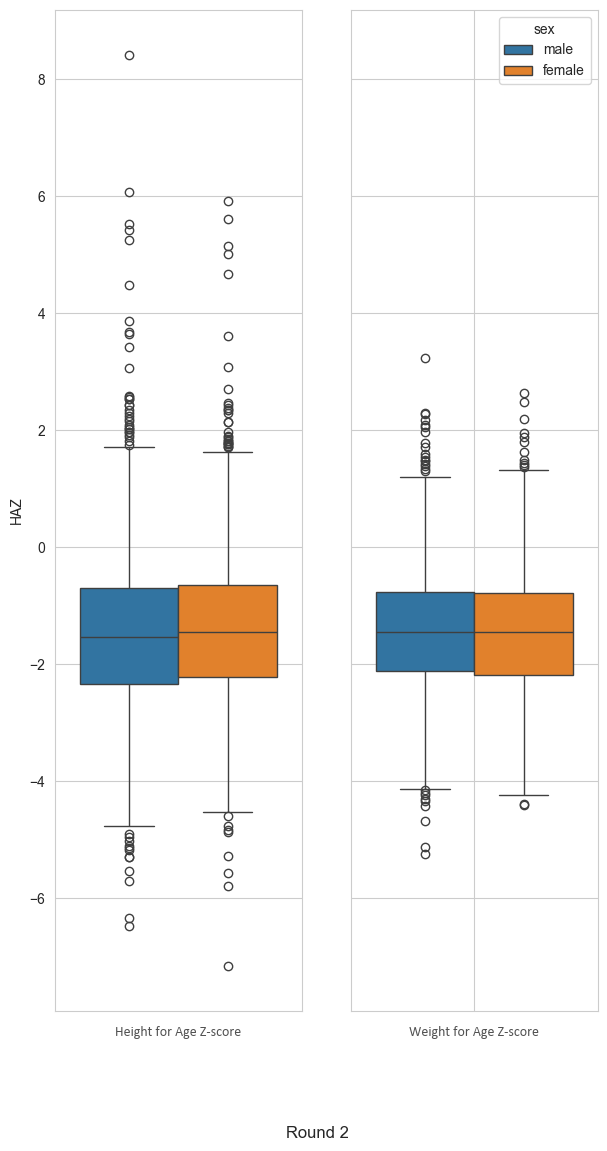

<Figure size 640x480 with 0 Axes>

In [ ]:
#  Set labels’ font parameters
sns.set_style("whitegrid")
font_color = '#525252'
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'

# Représentation graphique des regions du Bangladesh

## fig et ax représentent la base de la carte
fig, ax = plt.subplots(nrows=1,ncols=2,sharex=True, sharey=True, figsize=(7,13))

sns.boxplot(data=df_r2_anthr2, y="HAZ", hue="sex", ax=ax[0], legend=False)
ax[0].set_xlabel("Height for Age Z-score", fontsize=10, color=font_color, **hfont)


sns.boxplot(data=df_r2_anthr2, y="WAZ", hue="sex", ax=ax[1])
ax[1].set_xlabel("Weight for Age Z-score", fontsize=10, color=font_color, **hfont)

fig.supxlabel('Round 2')

plt.grid(True)
plt.show()

filename = 'r2_boxplot'
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)

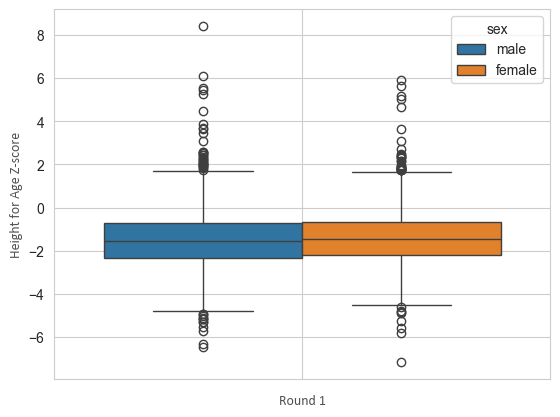

<Figure size 640x480 with 0 Axes>

In [ ]:
#  Set labels’ font parameters
sns.set_style("whitegrid")
font_color = '#525252'
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'

g1 = sns.boxplot(data=df_r2_anthr2, y="HAZ", hue="sex")

g1.set_xlabel("Round 1", fontsize=10, color=font_color, **hfont)
g1.set_ylabel("Height for Age Z-score", fontsize=10, color=font_color, **hfont)


#plt.legend(labels= ['Male', 'Female'], loc = (1.04,0.85))
plt.grid(True)
plt.show()

filename = 'HAZ_r1'
plt.savefig( os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)

Text(0.5, 1.0, '')

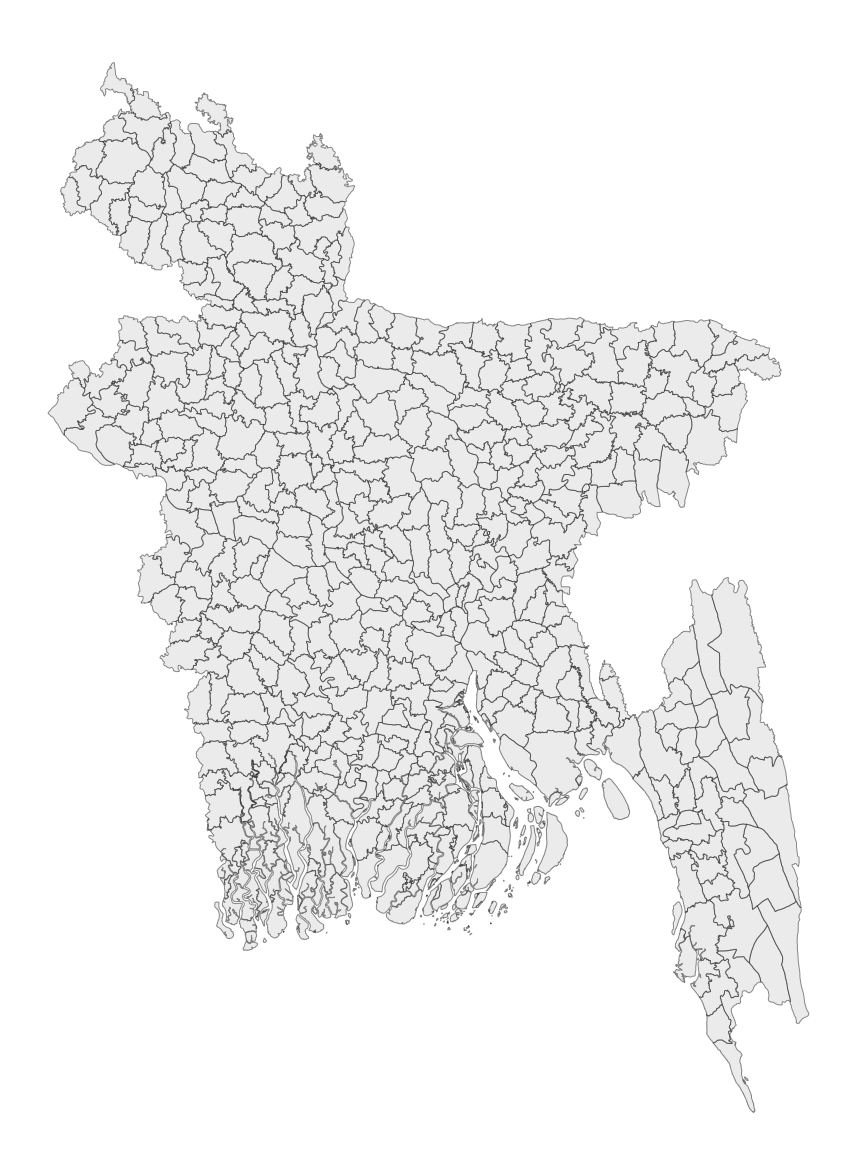

In [ ]:


# Représentation graphique des regions du Bangladesh

## fig et ax représentent la base de la carte
fig, ax = plt.subplots(figsize=(15,15))
#bgd_adm.apply(lambda x: ax.annotate(text=x['NAME_3'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
bgd_plot=bgd_adm.plot(ax=ax, color='lightgrey', edgecolor='black',lw=0.7, alpha=0.45)

# Sans axe 
ax.axis('off')

# using set_facecolor() method
ax.set_facecolor("red")

# Rajouter le titre
ax.set_title('', fontsize=23)

# Rajouter les coordonnées GPS des points sur la carte
#csm = shp_2007.plot(ax=bgd_plot, column='DHSREGNA', cmap='Paired', markersize=20, legend=True)

In [ ]:
#  Set labels’ font parameters
sns.set_style("whitegrid")
font_color = '#525252'
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))

sns.kdeplot(data=df_r2_anthr2, x="HAZ", hue="sex", ax=ax[0], legend=False)
ax[0].set_xlabel("Height for Age Z-score ", fontsize=10, color=font_color, **hfont)

sns.kdeplot(data=df_r2_anthr2, x="WAZ", hue="sex", ax=ax[1], legend=True)
ax[1].set_xlabel("Weight for Age Z-score ", fontsize=10, color=font_color, **hfont)


#plt.legend(labels= ['Male', 'Female'], loc = (1.04,0.85))
plt.grid(True)
plt.show()

filename = 'r2 - Z-score dist'
plt.savefig(os.getcwd() + '\\output\\img\\' + filename+'.jpeg', facecolor=facecolor)

Text(0.5, 1.0, '')

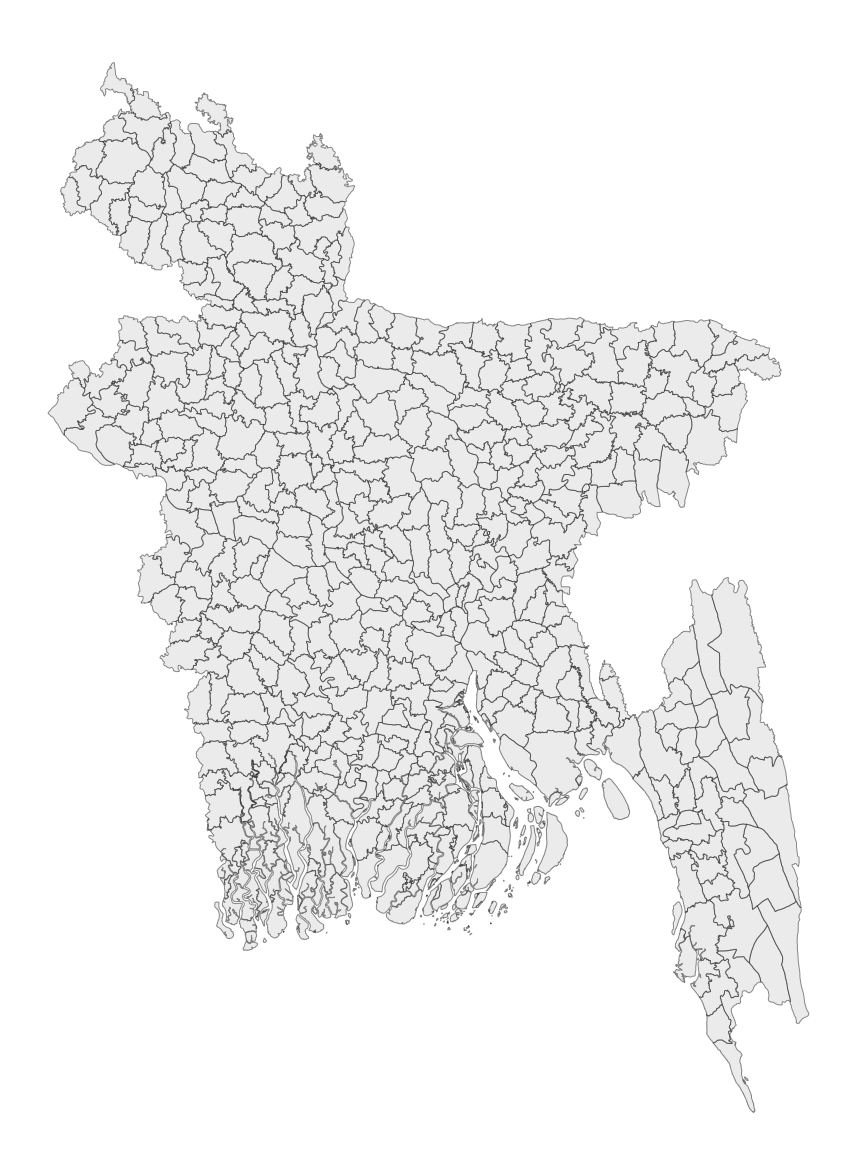

In [ ]:


# Représentation graphique des regions du Bangladesh

## fig et ax représentent la base de la carte
fig, ax = plt.subplots(figsize=(15,15))
#bgd_adm.apply(lambda x: ax.annotate(text=x['NAME_3'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
bgd_plot=bgd_adm.plot(ax=ax, color='lightgrey', edgecolor='black',lw=0.7, alpha=0.45)

# Sans axe 
ax.axis('off')

# using set_facecolor() method
ax.set_facecolor("red")

# Rajouter le titre
ax.set_title('', fontsize=23)

# Rajouter les coordonnées GPS des points sur la carte
#csm = shp_2007.plot(ax=bgd_plot, column='DHSREGNA', cmap='Paired', markersize=20, legend=True)

In [ ]:
lst_outcomes=['HWHAZWHO', 'HWWAZWHO', 'HWWHZWHO','HWBMIZWHO']
df[lst_outcomes] = df[lst_outcomes].apply(lambda x: x.replace(['Age in days out of plausible limits','Flagged cases','Missing','NIU (not in universe)'], np.NaN))
df[lst_outcomes] = df[lst_outcomes].apply(lambda x: pd.to_numeric(x, errors='coerce'))


C:\Users\ASUS\AppData\Local\Temp\ipykernel_20172\3933648467.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df[lst_outcomes] = df[lst_outcomes].apply(lambda x: x.replace(['Age in days out of plausible limits','Flagged cases','Missing','NIU (not in universe)'], np.NaN))


In [ ]:
lst_depvar=['KIDAGEMO', 'KIDSEX']
df[lst_outcomes] = df[lst_outcomes].apply(lambda x: x.replace(['Age in days out of plausible limits','Flagged cases','Missing','NIU (not in universe)'], np.NaN))
df[lst_outcomes] = df[lst_outcomes].apply(lambda x: pd.to_numeric(x, errors='coerce'))

In [ ]:
df = df.assign(**{col: df[col] / 100 for col in lst_outcomes})


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
YEAR,36529.0,2.007593e+03,4.992744e+00,2.000000e+03,2.004000e+03,2.007000e+03,2.011000e+03,2.014000e+03
IDHSPSU,36529.0,5.005108e+09,1.424356e+06,5.003000e+09,5.004000e+09,5.005000e+09,5.006001e+09,5.007001e+09
IDHSSTRATA,36529.0,5.005109e+08,1.424009e+05,5.003000e+08,5.004001e+08,5.005001e+08,5.006000e+08,5.007000e+08
PSU,36529.0,2.586824e+02,1.674505e+02,1.000000e+00,1.160000e+02,2.320000e+02,3.930000e+02,6.000000e+02
STRATA,36529.0,5.504279e+01,5.331771e+01,1.000000e+00,1.500000e+01,2.100000e+01,9.800000e+01,1.790000e+02
DOMAIN,36529.0,9.702182e+00,7.195199e+00,0.000000e+00,3.000000e+00,1.000000e+01,1.600000e+01,2.200000e+01
HHNUM,36529.0,7.425905e+01,6.913679e+01,1.000000e+00,2.800000e+01,5.900000e+01,9.500000e+01,5.330000e+02
CLUSTERNO,36529.0,2.586824e+02,1.674505e+02,1.000000e+00,1.160000e+02,2.320000e+02,3.930000e+02,6.000000e+02
LINENO,36529.0,2.904596e+00,2.040628e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,2.700000e+01
BIDX,36529.0,1.203154e+00,4.406707e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.000000e+00


In [ ]:
df['YEAR'] = df['YEAR'].astype("category")

In [ ]:

# duplication
df[df.duplicated()]

,SAMPLE,SAMPLESTR,COUNTRY,YEAR,IDHSPID,IDHSHID,DHSID,IDHSPSU,IDHSSTRATA,CASEID,...,KIDAGEMO,HWWEIGHT,HWHEIGHT,HWWHYNOTMEAS,HWDAYOFBIRTH,HWHAZWHO,HWWAZWHO,HWWHZWHO,HWBMIZWHO,born_after


**Observations**:
No duplicate observations.

### Round 1 data

#### Let's check the percentage of missing values and data description

In [ ]:
# Missing values
## for id number there is not missing information
pd.DataFrame(data={'% of Missing Values':round(df_r1.isna().sum()/df_r1.isna().count()*100,2),'Nbr of Missing Values':df_r1.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


,% of Missing Values,Nbr of Missing Values
division_code,0.0,0
hh_id,0.0,0
hh_id_cmplt,0.0,0
date_int,0.0,0
sample_type,0.0,0
first_v_year,0.0,0
first_v_month,0.0,0
first_v_day,0.0,0
hh_ethnic_group,0.0,0
hh_head_religion,0.0,0


In [ ]:
# Missing values
## for id number there is 31.18 missing information, I will look at why there is nan in the hh_id
pd.DataFrame(data={'% of Missing Values':round(df_r1_ftf.isna().sum()/df_r1_ftf.isna().count()*100,2),'Nbr of Missing Values':df_r1_ftf.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)

,% of Missing Values,Nbr of Missing Values
hh_id,91.18,42877
div_name,0.00,0
education_high,0.00,0
literacy_hhm,0.00,0
marital_status_hhm,0.00,0
relation_head_hh,0.00,0
age_hhm,0.00,0
sexe_hhm,0.00,0
union_name,0.00,0
union_code,0.00,0


In [ ]:
# Data description (Nan because not adequate here)
df_r1_ftf.describe(include='category').T

#df_r1_ftf.describe(include='float64').T

,count,unique,top,freq
dcode,47027,20,Jessore,5489
uzcode,47027,50,Daulat Khan,1290
uncode,47027,50,Saidpur,1290
village_name,47027,50,Char Bara Lamchhi Dhali(P,1290
sexe_hhm,47027,2,Female,23880
relation_head_hh,47027,16,Son/daughter,19409
marital_status_hhm,47027,5,Married,23631
literacy_hhm,47027,4,Can read and write,27737
education_high,47027,27,Never attended school,16093


In [ ]:
# Missing values
## for anthropometric data for more than 5 years old
pd.DataFrame(data={'% of Missing Values':round(df_r1_anthr1.isna().sum()/df_r1_anthr1.isna().count()*100,2),'Nbr of Missing Values':df_r1_anthr1.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


,% of Missing Values,Nbr of Missing Values
are_you_lactating,48.63,9926
are_you_pregnant,48.56,9912
height_cm,6.56,1338
weight_kg,6.40,1306
index,0.00,0
hh_id,0.00,0
hhm_id,0.00,0
if_not_measured_why,0.00,0
sample_type,0.00,0
member_id,0.00,0


In [ ]:
# Missing values
## for anthropometric data for less than 5 years old
pd.DataFrame(data={'% of Missing Values':round(df_r1_anthr2.isna().sum()/df_r1_anthr2.isna().count()*100,2),'Nbr of Missing Values':df_r1_anthr2.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


,% of Missing Values,Nbr of Missing Values
if_not_week_month,93.61,2316
height_cm,4.24,105
weight_kg,3.15,78
month_birth,0.65,16
year_birth,0.65,16
date_birth,0.65,16
index,0.00,0
hh_id,0.00,0
hhm_id,0.00,0
mother_id,0.00,0


In [ ]:
# Missing values
## for other information data

pd.DataFrame(data={'% of Missing Values':round(df_r1_SE.isna().sum()/df_r1_SE.isna().count()*100,2),'Nbr of Missing Values':df_r1_SE.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


,% of Missing Values,Nbr of Missing Values
index,0.0,0
hh_id,0.0,0
hhm_id,0.0,0
hhm_sex,0.0,0
hhm_age,0.0,0
relation_hhh,0.0,0
marital_status_hhm,0.0,0
literacy_hhm,0.0,0
education_high,0.0,0
curr_att_school,0.0,0



#### The data types of the columns for the dataset and data description

In [ ]:
# Data description
df_r1.describe().T

,count,mean,min,25%,50%,75%,max,std
first_v_day,6503.0,16.337075,1.0,9.0,17.0,24.0,31.0,8.944041
first_v_month,6503.0,6.234661,1.0,1.0,2.0,12.0,12.0,5.008143
first_v_year,6503.0,2011.523451,2011.0,2011.0,2012.0,2012.0,2012.0,0.499488
date_int,6503,2012-01-01 12:34:52.572658944,2011-10-22 00:00:00,2011-12-05 00:00:00,2012-01-03 00:00:00,2012-01-31 00:00:00,2012-03-09 00:00:00,NaN


In [ ]:
# Data description
df_r1_anthr1.describe().T

,count,mean,std,min,25%,50%,75%,max
index,20410.0,13007.350220,6984.258995,236.0,6835.250000,13356.500000,19270.750000,24373.000000
weight_kg,19104.0,42.095588,14.213092,8.8,33.700001,43.900002,51.500000,98.900002
height_cm,19072.0,147.193000,17.186252,64.0,141.600006,151.000000,158.899994,198.399994


In [ ]:
# Data description
df_r1_anthr2.describe().T

,count,mean,min,25%,50%,75%,max,std
index,2474.0,1540.669361,21.0,822.25,1553.5,2291.75,2910.0,832.803547
childbirth_day,2474.0,13.669766,1.0,5.0,14.0,21.0,31.0,9.025488
month_birth,2458.0,6.691212,1.0,3.0,7.0,10.0,12.0,3.589239
year_birth,2458.0,2009.070382,2006.0,2008.0,2009.0,2010.0,2012.0,1.410875
weight_kg,2396.0,10.220614,1.6,8.1,10.3,12.4,19.6,3.003161
height_cm,2369.0,81.571389,42.200001,72.0,82.400002,92.099998,126.199997,13.448786
date_birth,2458,2009-07-30 14:22:21.578519296,2006-11-15 00:00:00,2008-05-01 00:00:00,2009-08-23 12:00:00,2010-10-25 18:00:00,2012-02-22 00:00:00,NaN


In [ ]:
# Data description
df_r1_SE.describe().T

,count,mean,std,min,25%,50%,75%,max
index,22884.0,14547.935282,7817.253589,257.0,7657.75,14763.5,21563.25,27284.0
hhm_age,22884.0,26.326429,19.752130,0.0,10.00,22.0,40.00,120.0


### Round 2 data

#### Let's check the percentage of missing values and data description

In [ ]:
# Missing values
## for id number there is not missing information
pd.DataFrame(data={'% of Missing Values':round(df_r2.isna().sum()/df_r2.isna().count()*100,2),'Nbr of Missing Values':df_r2.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


,% of Missing Values,Nbr of Missing Values
census_nbr,99.96,6712
hh_ethnic_group,0.86,58
hh_head_religion,0.80,54
hh_id,0.00,0
division,0.00,0
hh_id_cmplt,0.00,0
hh_split,0.00,0
hh_id_parent,0.00,0
interview_status,0.00,0
sample_type,0.00,0


In [ ]:
# Missing values
## for anthropometric data for more than 5 years old
pd.DataFrame(data={'% of Missing Values':round(df_r2_anthr1.isna().sum()/df_r2_anthr1.isna().count()*100,2),'Nbr of Missing Values':df_r2_anthr1.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


,% of Missing Values,Nbr of Missing Values
are_you_pregnant,46.95,11545
are_you_lactating,46.95,11545
height_cm,7.10,1747
weight_kg,6.91,1699
if_not_measured_why,0.02,6
hh_id,0.00,0
hhm_id,0.00,0
member_id,0.00,0


In [ ]:
# Missing values
## for anthropometric data for less than 5 years old
pd.DataFrame(data={'% of Missing Values':round(df_r2_anthr2.isna().sum()/df_r2_anthr2.isna().count()*100,2),'Nbr of Missing Values':df_r2_anthr2.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


,% of Missing Values,Nbr of Missing Values
month_birth,100.00,2763
year_birth,100.00,2763
date_birth,100.00,2763
if_not_week_month,98.12,2711
height_cm,5.10,141
weight_kg,4.74,131
age_month,0.76,21
age_days,0.76,21
if_not_measured_why,0.04,1
index,0.00,0


In [ ]:
# Missing values
## for other information data

pd.DataFrame(data={'% of Missing Values':round(df_r2_SE.isna().sum()/df_r2_SE.isna().count()*100,2),'Nbr of Missing Values':df_r2_SE.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


,% of Missing Values,Nbr of Missing Values
curr_att_school,42.96,14733
hhm_sex,12.44,4265
hhm_age,12.44,4265
relation_hhh,12.44,4265
marital_status_hhm,12.44,4265
literacy_hhm,12.44,4265
education_high,12.44,4265
hh_id,0.00,0
hhm_id,0.00,0
member_id,0.00,0



#### The data types of the columns for the dataset and data description

In [ ]:
# Data description
df_r2.describe().T

,count,mean,std,min,25%,50%,75%,max
dcode,6715.0,5.015920e+01,2.790235e+01,1.000000e+00,2.900000e+01,5.000000e+01,7.500000e+01,9.400000e+01
uzcode,6715.0,5.064663e+03,2.793335e+03,1.080000e+02,2.903000e+03,5.079000e+03,7.536000e+03,9.486000e+03
uncode,6715.0,5.065140e+05,2.793365e+05,1.081700e+04,2.903100e+05,5.079500e+05,7.536380e+05,9.486790e+05
vcode,6715.0,5.065144e+10,2.793365e+10,1.081701e+09,2.903100e+10,5.079501e+10,7.536383e+10,9.486796e+10


In [ ]:
# Data description
df_r2_anthr1.describe().T

,count,mean,std,min,25%,50%,75%,max
weight_kg,22892.0,44.11604,14.591319,9.0,35.9,45.8,53.7,103.6
height_cm,22844.0,148.58797,16.184666,89.8,143.5,151.7,159.3,189.2


In [ ]:
# Data description
df_r2_anthr2.describe().T

,count,mean,min,25%,50%,75%,max,std
index,2763.0,3328.324647,5.0,1586.5,3269.0,5137.0,6859.0,1980.390908
childbirth_day,2763.0,14.170105,1.0,7.0,14.0,21.0,31.0,8.785769
month_birth,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year_birth,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weight_kg,2632.0,10.47304,2.3,8.4,10.7,12.6,23.7,2.95334
height_cm,2622.0,83.284443,46.5,73.7,85.1,93.5,119.3,13.033496
age_month,2742.0,29.61488,1.0,15.0,30.0,44.0,60.0,17.028693
age_days,2742.0,888.446389,30.0,450.0,900.0,1320.0,1800.0,510.860803
date_birth,0,NaT,NaT,NaT,NaT,NaT,NaT,NaN


In [ ]:
# Data description
df_r2_SE.describe().T

,count,mean,std,min,25%,50%,75%,max
hhm_age,30032.0,27.8127,20.301787,0.0,11.0,24.0,43.0,123.0


### Round 3 data

#### Let's check the percentage of missing values and data description

In [ ]:
# Missing values
## for id number there is not missing information
pd.DataFrame(data={'% of Missing Values':round(df_r3.isna().sum()/df_r2.isna().count()*100,2),'Nbr of Missing Values':df_r3.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


,% of Missing Values,Nbr of Missing Values
hh_ethnic_group,6.05,406.0
hh_head_religion,6.05,406.0
district_code,0.00,0.0
div_name,0.00,0.0
division,0.00,0.0
hh_id,0.00,0.0
hh_id_cmplt,0.00,0.0
hh_id_parent,0.00,0.0
hh_split,0.00,0.0
interview_status,0.00,0.0


In [ ]:
# Missing values
## for anthropometric data for more than 5 years old
pd.DataFrame(data={'% of Missing Values':round(df_r3_anthr1.isna().sum()/df_r3_anthr1.isna().count()*100,2),'Nbr of Missing Values':df_r3_anthr1.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


,% of Missing Values,Nbr of Missing Values
are_you_pregnant,46.19,9594
are_you_lactating,46.19,9594
height_cm,3.42,711
weight_kg,3.19,662
hh_id,0.00,0
hhm_id,0.00,0
if_not_measured_why,0.00,0
member_id,0.00,0


In [ ]:
# Missing values
## for anthropometric data for less than 5 years old
pd.DataFrame(data={'% of Missing Values':round(df_r3_anthr2.isna().sum()/df_r3_anthr2.isna().count()*100,2),'Nbr of Missing Values':df_r3_anthr2.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


,% of Missing Values,Nbr of Missing Values
age_days,61.21,1441
age_month,61.21,1441
BMIZ,3.27,77
height_cm,3.27,77
HAZ,3.27,77
weight_kg,3.10,73
WAZ,3.10,73
index,0.00,0
year_birth,0.00,0
flag,0.00,0


In [ ]:
# Missing values
## for other information data

pd.DataFrame(data={'% of Missing Values':round(df_r3_SE.isna().sum()/df_r3_SE.isna().count()*100,2),'Nbr of Missing Values':df_r3_SE.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


,% of Missing Values,Nbr of Missing Values
curr_att_school,52.21,16881
hhm_sex,26.73,8643
hhm_age,26.73,8643
relation_hhh,26.73,8643
marital_status_hhm,26.73,8643
literacy_hhm,26.73,8643
education_high,26.73,8643
hh_id,0.00,0
hhm_id,0.00,0
member_id,0.00,0



#### The data types of the columns for the dataset and data description

In [ ]:
# Data description
df_r3.describe().T

,count,mean,min,25%,50%,75%,max,std
district_code,6011.0,33.342372,1.0,15.0,34.0,49.0,65.0,19.56955
first_v_month,6011.0,3.745799,1.0,2.0,3.0,4.0,12.0,3.109258
first_v_year,6011.0,2018.872068,2018.0,2019.0,2019.0,2019.0,2019.0,0.334042
date_int,6011,2019-02-06 03:20:59.490933248,2018-11-01 00:00:00,2019-02-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,NaN


In [ ]:
# Data description
df_r3_anthr1.describe().T

,count,mean,std,min,25%,50%,75%,max
weight_kg,20110.0,46.492444,15.017934,10.8,38.3,47.8,56.2,103.2
height_cm,20061.0,149.655590,15.380788,90.5,144.6,152.2,160.0,189.6


In [ ]:
# Data description
df_r3_anthr2.describe().T

,count,mean,std,min,25%,50%,75%,max
index,2354.0,3031.305438,1746.843556,3.00,1492.25,3000.50,4600.50,5979.00
weight_kg,2281.0,10.787089,3.157997,2.40,8.70,10.90,13.00,24.60
height_cm,2277.0,83.567633,13.973713,40.40,73.60,85.10,94.60,116.80
birth_order,2354.0,2.277400,1.349609,1.00,1.00,2.00,3.00,13.00
age_month,913.0,3.004458,0.689961,1.00,2.50,3.00,3.50,5.00
HAZ,2277.0,-1.466781,1.287835,-10.65,-2.25,-1.50,-0.74,4.90
WAZ,2281.0,-1.260859,1.071001,-6.02,-1.95,-1.28,-0.59,2.99
BMIZ,2277.0,-0.493513,1.234629,-9.10,-1.21,-0.53,0.21,13.30
flag,2354.0,0.001699,0.041195,0.00,0.00,0.00,0.00,1.00
age_days,913.0,90.133735,20.698821,30.00,75.00,90.00,105.00,150.00


In [ ]:
# Data description
df_r3_SE.describe().T

,count,mean,std,min,25%,50%,75%,max
hhm_age,23689.0,28.148845,20.533092,0.0,11.0,24.0,42.0,118.0


#### Let's check the percentage of missing values and data description

In [ ]:
# Missing values
## for id number there is not missing information
pd.DataFrame(data={'% of Missing Values':round(df_r2.isna().sum()/df_r2.isna().count()*100,2),'Nbr of Missing Values':df_r2.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


,% of Missing Values,Nbr of Missing Values
census_nbr,99.96,6712
hh_ethnic_group,0.86,58
hh_head_religion,0.80,54
hh_id,0.00,0
division,0.00,0
hh_id_cmplt,0.00,0
hh_split,0.00,0
hh_id_parent,0.00,0
interview_status,0.00,0
sample_type,0.00,0


In [ ]:
# Missing values
## for anthropometric data for more than 5 years old
pd.DataFrame(data={'% of Missing Values':round(df_r2_anthr1.isna().sum()/df_r2_anthr1.isna().count()*100,2),'Nbr of Missing Values':df_r2_anthr1.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


,% of Missing Values,Nbr of Missing Values
are_you_pregnant,46.95,11545
are_you_lactating,46.95,11545
height_cm,7.10,1747
weight_kg,6.91,1699
if_not_measured_why,0.02,6
hh_id,0.00,0
hhm_id,0.00,0
member_id,0.00,0


In [ ]:
# Missing values
## for anthropometric data for less than 5 years old
pd.DataFrame(data={'% of Missing Values':round(df_r2_anthr2.isna().sum()/df_r2_anthr2.isna().count()*100,2),'Nbr of Missing Values':df_r2_anthr2.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


,% of Missing Values,Nbr of Missing Values
month_birth,100.00,2763
year_birth,100.00,2763
date_birth,100.00,2763
if_not_week_month,98.12,2711
height_cm,5.10,141
weight_kg,4.74,131
age_month,0.76,21
age_days,0.76,21
if_not_measured_why,0.04,1
index,0.00,0


In [ ]:
# Missing values
## for other information data

pd.DataFrame(data={'% of Missing Values':round(df_r2_SE.isna().sum()/df_r2_SE.isna().count()*100,2),'Nbr of Missing Values':df_r2_SE.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


,% of Missing Values,Nbr of Missing Values
curr_att_school,42.96,14733
hhm_sex,12.44,4265
hhm_age,12.44,4265
relation_hhh,12.44,4265
marital_status_hhm,12.44,4265
literacy_hhm,12.44,4265
education_high,12.44,4265
hh_id,0.00,0
hhm_id,0.00,0
member_id,0.00,0



#### The data types of the columns for the dataset and data description

In [ ]:
# Data description
df_r2.describe().T

,count,mean,std,min,25%,50%,75%,max
dcode,6715.0,5.015920e+01,2.790235e+01,1.000000e+00,2.900000e+01,5.000000e+01,7.500000e+01,9.400000e+01
uzcode,6715.0,5.064663e+03,2.793335e+03,1.080000e+02,2.903000e+03,5.079000e+03,7.536000e+03,9.486000e+03
uncode,6715.0,5.065140e+05,2.793365e+05,1.081700e+04,2.903100e+05,5.079500e+05,7.536380e+05,9.486790e+05
vcode,6715.0,5.065144e+10,2.793365e+10,1.081701e+09,2.903100e+10,5.079501e+10,7.536383e+10,9.486796e+10


In [ ]:
# Data description
df_r2_anthr1.describe().T

,count,mean,std,min,25%,50%,75%,max
weight_kg,22892.0,44.11604,14.591319,9.0,35.9,45.8,53.7,103.6
height_cm,22844.0,148.58797,16.184666,89.8,143.5,151.7,159.3,189.2


In [ ]:
# Data description
df_r2_anthr2.describe().T

,count,mean,min,25%,50%,75%,max,std
index,2763.0,3328.324647,5.0,1586.5,3269.0,5137.0,6859.0,1980.390908
childbirth_day,2763.0,14.170105,1.0,7.0,14.0,21.0,31.0,8.785769
month_birth,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year_birth,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weight_kg,2632.0,10.47304,2.3,8.4,10.7,12.6,23.7,2.95334
height_cm,2622.0,83.284443,46.5,73.7,85.1,93.5,119.3,13.033496
age_month,2742.0,29.61488,1.0,15.0,30.0,44.0,60.0,17.028693
age_days,2742.0,888.446389,30.0,450.0,900.0,1320.0,1800.0,510.860803
date_birth,0,NaT,NaT,NaT,NaT,NaT,NaT,NaN


In [ ]:
# Data description
df_r2_SE.describe().T

,count,mean,std,min,25%,50%,75%,max
hhm_age,30032.0,27.8127,20.301787,0.0,11.0,24.0,43.0,123.0


#### Let's check the percentage of missing values and data description

In [ ]:
# Missing values
## for id number there is not missing information
pd.DataFrame(data={'% of Missing Values':round(df_r1.isna().sum()/df_r1.isna().count()*100,2),'Nbr of Missing Values':df_r1.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


,% of Missing Values,Nbr of Missing Values
division_code,0.0,0
hh_id,0.0,0
hh_id_cmplt,0.0,0
date_int,0.0,0
sample_type,0.0,0
first_v_year,0.0,0
first_v_month,0.0,0
first_v_day,0.0,0
hh_ethnic_group,0.0,0
hh_head_religion,0.0,0


In [ ]:
# Missing values
## for id number there is 31.18 missing information, I will look at why there is nan in the hh_id
pd.DataFrame(data={'% of Missing Values':round(df_r1_ftf.isna().sum()/df_r1_ftf.isna().count()*100,2),'Nbr of Missing Values':df_r1_ftf.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)

,% of Missing Values,Nbr of Missing Values
hh_id,91.18,42877
div_name,0.00,0
education_high,0.00,0
literacy_hhm,0.00,0
marital_status_hhm,0.00,0
relation_head_hh,0.00,0
age_hhm,0.00,0
sexe_hhm,0.00,0
union_name,0.00,0
union_code,0.00,0


In [ ]:
# Data description (Nan because not adequate here)
df_r1_ftf.describe(include='category').T

#df_r1_ftf.describe(include='float64').T

,count,unique,top,freq
dcode,47027,20,Jessore,5489
uzcode,47027,50,Daulat Khan,1290
uncode,47027,50,Saidpur,1290
village_name,47027,50,Char Bara Lamchhi Dhali(P,1290
sexe_hhm,47027,2,Female,23880
relation_head_hh,47027,16,Son/daughter,19409
marital_status_hhm,47027,5,Married,23631
literacy_hhm,47027,4,Can read and write,27737
education_high,47027,27,Never attended school,16093


In [ ]:
# Missing values
## for anthropometric data for more than 5 years old
pd.DataFrame(data={'% of Missing Values':round(df_r1_anthr1.isna().sum()/df_r1_anthr1.isna().count()*100,2),'Nbr of Missing Values':df_r1_anthr1.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


,% of Missing Values,Nbr of Missing Values
are_you_lactating,48.63,9926
are_you_pregnant,48.56,9912
height_cm,6.56,1338
weight_kg,6.40,1306
index,0.00,0
hh_id,0.00,0
hhm_id,0.00,0
if_not_measured_why,0.00,0
sample_type,0.00,0
member_id,0.00,0


In [ ]:
# Missing values
## for anthropometric data for less than 5 years old
pd.DataFrame(data={'% of Missing Values':round(df_r1_anthr2.isna().sum()/df_r1_anthr2.isna().count()*100,2),'Nbr of Missing Values':df_r1_anthr2.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


,% of Missing Values,Nbr of Missing Values
if_not_week_month,93.61,2316
height_cm,4.24,105
weight_kg,3.15,78
month_birth,0.65,16
year_birth,0.65,16
date_birth,0.65,16
index,0.00,0
hh_id,0.00,0
hhm_id,0.00,0
mother_id,0.00,0


In [ ]:
# Missing values
## for other information data

pd.DataFrame(data={'% of Missing Values':round(df_r1_SE.isna().sum()/df_r1_SE.isna().count()*100,2),'Nbr of Missing Values':df_r1_SE.isna().sum()}).sort_values(by='% of Missing Values',ascending=False)


,% of Missing Values,Nbr of Missing Values
index,0.0,0
hh_id,0.0,0
hhm_id,0.0,0
hhm_sex,0.0,0
hhm_age,0.0,0
relation_hhh,0.0,0
marital_status_hhm,0.0,0
literacy_hhm,0.0,0
education_high,0.0,0
curr_att_school,0.0,0



#### The data types of the columns for the dataset and data description

In [ ]:
# Data description
df_r1.describe().T

,count,mean,min,25%,50%,75%,max,std
first_v_day,6503.0,16.337075,1.0,9.0,17.0,24.0,31.0,8.944041
first_v_month,6503.0,6.234661,1.0,1.0,2.0,12.0,12.0,5.008143
first_v_year,6503.0,2011.523451,2011.0,2011.0,2012.0,2012.0,2012.0,0.499488
date_int,6503,2012-01-01 12:34:52.572658944,2011-10-22 00:00:00,2011-12-05 00:00:00,2012-01-03 00:00:00,2012-01-31 00:00:00,2012-03-09 00:00:00,NaN


In [ ]:
# Data description
df_r1_anthr1.describe().T

,count,mean,std,min,25%,50%,75%,max
index,20410.0,13007.350220,6984.258995,236.0,6835.250000,13356.500000,19270.750000,24373.000000
weight_kg,19104.0,42.095588,14.213092,8.8,33.700001,43.900002,51.500000,98.900002
height_cm,19072.0,147.193000,17.186252,64.0,141.600006,151.000000,158.899994,198.399994


In [ ]:
# Data description
df_r1_anthr2.describe().T

,count,mean,min,25%,50%,75%,max,std
index,2474.0,1540.669361,21.0,822.25,1553.5,2291.75,2910.0,832.803547
childbirth_day,2474.0,13.669766,1.0,5.0,14.0,21.0,31.0,9.025488
month_birth,2458.0,6.691212,1.0,3.0,7.0,10.0,12.0,3.589239
year_birth,2458.0,2009.070382,2006.0,2008.0,2009.0,2010.0,2012.0,1.410875
weight_kg,2396.0,10.220614,1.6,8.1,10.3,12.4,19.6,3.003161
height_cm,2369.0,81.571389,42.200001,72.0,82.400002,92.099998,126.199997,13.448786
date_birth,2458,2009-07-30 14:22:21.578519296,2006-11-15 00:00:00,2008-05-01 00:00:00,2009-08-23 12:00:00,2010-10-25 18:00:00,2012-02-22 00:00:00,NaN


In [ ]:
# Data description
df_r1_SE.describe().T

,count,mean,std,min,25%,50%,75%,max
index,22884.0,14547.935282,7817.253589,257.0,7657.75,14763.5,21563.25,27284.0
hhm_age,22884.0,26.326429,19.752130,0.0,10.00,22.0,40.00,120.0
